# 2. Clustering

As the first step towards our recommender engine, we need to group the users into clusters. This notebook begins with a building our dataframe by merging all data together to all_orders. Then we proceed to feature generate aisles per share before doing a PCA to reduce the number of features (products that is) to increase performance before using kmeans to cluster into the optimal set op segments. 

In [1]:
import pandas as pd
import sys
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
import pyarrow as pa
import pyarrow.parquet as pq

## 2.1 Preparing the dataframe 

In [2]:
#loading all the data from the instacart zip 
products = pd.read_csv('../data/products.csv')
aisles = pd.read_csv('../data/aisles.csv')
departments = pd.read_csv('../data/departments.csv')
order_products_prior = pd.read_csv('../data/order_products__prior.csv')
order_products_train = pd.read_csv('../data/order_products__train.csv')
orders = pd.read_csv('../data/orders.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')

In [3]:
#creating one big dataframe called all_orders with most of the features included. 
all_orders = pd.concat([order_products_prior,order_products_train])
all_orders = all_orders.merge(orders[['order_id','user_id']], on='order_id', how='inner')
all_orders = all_orders.merge(products, on = 'product_id', how='inner')
all_orders = all_orders.merge(departments, on = 'department_id', how='inner')
all_orders = all_orders.merge(aisles, on = 'aisle_id', how='inner')


## 2.2 Feature Engineering "Aisle Share"

Before running our kmeans clustering algorithm, we wanted to develop a feature that would capture the relationship between the products purchased and aisles per user. We did this by counting the total number of products by aisle over total products purchased. 

In [4]:
#How many products the user bought by aisle over all their orders. 
cnt_per_aisle = all_orders[['user_id','aisle','product_name']].groupby(['user_id', 'aisle']).count().reset_index() 

cnt_per_aisle = cnt_per_aisle.rename(columns={'product_name':'product_cnt_per_aisle'})

In [5]:
cnt_per_aisle

,user_id,aisle,product_cnt_per_aisle
0,1,candy chocolate,2
1,1,cereal,4
2,1,cream,3
3,1,fresh fruits,5
4,1,milk,1
...,...,...,...
5919835,206209,soft drinks,11
5919836,206209,soy lactosefree,10
5919837,206209,spices seasonings,1
5919838,206209,trash bags liners,1


In [6]:
#Total product purchased by user id 
ttl_per_user = cnt_per_aisle.groupby(["user_id"]).sum()
ttl_per_user

,product_cnt_per_aisle
user_id,
1,70
2,226
3,88
4,18
5,46
...,...
206205,51
206206,285
206207,223


In [7]:
#calculating the aisle share by user id 
aisle_share_per_user = cnt_per_aisle.merge(ttl_per_user, how="left", on="user_id")
aisle_share_per_user["aisle_share"] = aisle_share_per_user["product_cnt_per_aisle_x"] / aisle_share_per_user["product_cnt_per_aisle_y"]
aisle_share_per_user.drop(["product_cnt_per_aisle_x", "product_cnt_per_aisle_y"], axis=1, inplace=True)
aisle_share_per_user

,user_id,aisle,aisle_share
0,1,candy chocolate,0.028571
1,1,cereal,0.057143
2,1,cream,0.042857
3,1,fresh fruits,0.071429
4,1,milk,0.014286
...,...,...,...
5919835,206209,soft drinks,0.080292
5919836,206209,soy lactosefree,0.072993
5919837,206209,spices seasonings,0.007299
5919838,206209,trash bags liners,0.007299


## 2.3 Preparing our dataset for dimensionality reduction

Before performing our principal component analysis we need to adjust our dataframe using pivot to transform our aisle per share into columns (features). 

In [8]:
#Setting aisles as columns by user id using pivot. 
aisle_share_pivot = aisle_share_per_user.pivot(index="user_id", columns="aisle", values="aisle_share")
aisle_share_pivot

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.014286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028571
2,NaN,0.013274,NaN,NaN,NaN,NaN,0.008850,NaN,NaN,NaN,...,0.013274,0.004425,0.004425,NaN,NaN,NaN,NaN,0.008850,NaN,0.185841
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.045455,0.011364,NaN,NaN,NaN,NaN,NaN,0.022727,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.055556,NaN,NaN,NaN,0.055556,NaN,NaN
5,0.021739,0.086957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.065217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,NaN,NaN,0.019608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.176471
206206,NaN,0.014035,NaN,NaN,NaN,NaN,0.014035,0.003509,NaN,NaN,...,0.003509,NaN,NaN,NaN,NaN,0.003509,NaN,0.003509,NaN,NaN
206207,NaN,NaN,NaN,NaN,0.004484,NaN,NaN,NaN,NaN,NaN,...,0.013453,0.017937,NaN,0.008969,0.004484,NaN,NaN,0.049327,NaN,0.067265


## 2.4 Dimensionality reduction using PCA 
with 134 features (columns from our pivot) PCA can help us reduce the complexity and size by lowering the dimensionality without loosing out on too much explained variance. 

### 2.4.1 Finding the optimal number of dimensions

In [9]:
#transforming our using PCA and finding the optimal explained variance with a given threshold of 80%
pca = PCA()
pca.fit_transform(aisle_share_pivot.fillna(0))
cumsum = np.cumsum(pca.explained_variance_ratio_)
threshold = 0.80 #tried differnet trsh
d = np.argmax(cumsum >= threshold) + 1

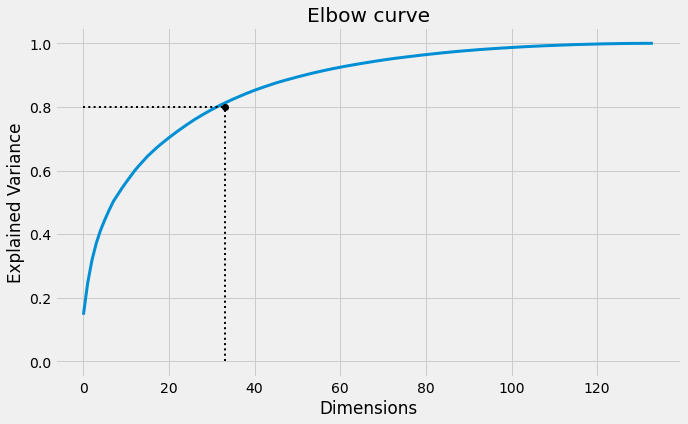

In [10]:
#graphically displaying the optimal components 
plt.style.use("fivethirtyeight")
plt.figure(figsize=(10,6))
plt.plot(cumsum, linewidth=3)
plt.title("Elbow curve")
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, threshold], "k:", linewidth=2)
plt.plot([0, d], [threshold, threshold], "k:",linewidth=2)
plt.plot(d, threshold, "ko")
plt.grid(True)
plt.show()

In [11]:
d

33

Using the elbow curve and a threshold of 80% explained variance, we find the optimal nubmer of dimensions to be 33. We will now create a seperate 

### 2.4.2 Reducing our dataframe using 33 components

In [12]:
#creating a dataframe with d number of components. 
pca = PCA(n_components=d)
prinicpalComponents = pca.fit_transform(aisle_share_pivot.fillna(0))

PCA_components = pd.DataFrame(prinicpalComponents)

In [13]:
PCA_components

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,-0.122382,0.028613,-0.047847,0.012767,-0.075248,-0.111791,-0.100797,0.088232,-0.063932,-0.002256,...,0.002025,0.079287,0.025060,0.104362,0.029456,-0.021527,0.006139,0.008043,-0.005072,-0.011461
1,-0.034421,0.111616,-0.064131,-0.109468,0.073280,-0.029577,-0.049187,-0.058602,-0.010482,-0.018558,...,0.038159,0.006804,-0.005423,-0.003019,-0.000217,0.002795,0.006918,-0.022622,-0.019917,0.027312
2,0.063256,0.104112,0.000496,-0.014156,-0.047741,0.111107,-0.031845,0.013015,0.011859,0.004805,...,0.058287,-0.005193,-0.000366,0.015456,-0.005741,-0.004336,-0.003815,0.003469,-0.014939,-0.017511
3,-0.094301,0.052755,0.001040,-0.005059,-0.071586,-0.017778,-0.025068,-0.039001,0.009993,-0.014100,...,0.005272,0.006558,-0.000022,0.010985,-0.013485,0.016255,-0.007338,-0.064575,0.060007,0.033193
4,0.089432,-0.031068,-0.022805,-0.011826,0.042319,0.111460,-0.015760,0.100975,0.025137,-0.036416,...,-0.005049,0.007773,0.002408,-0.007447,-0.000222,-0.001055,-0.001942,0.004315,-0.009519,-0.003642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,0.001716,0.084855,-0.065398,-0.068637,0.114987,-0.028522,0.020656,0.023942,-0.027590,-0.016797,...,-0.005254,-0.025726,-0.007686,0.028825,-0.000518,-0.001827,0.017793,-0.016729,-0.005403,0.039125
206205,-0.089658,-0.046734,-0.048290,0.012790,-0.059581,-0.000544,-0.013947,-0.042906,0.143137,-0.060002,...,0.002714,0.044255,-0.008106,0.031527,0.033007,-0.031681,0.002545,-0.014003,-0.004219,-0.017396
206206,-0.024827,-0.013520,-0.003968,-0.030921,0.032987,0.020687,0.037639,0.032876,-0.022797,-0.002543,...,0.006776,-0.003637,0.013538,-0.009709,0.004822,-0.004506,0.005795,-0.008193,-0.008830,0.000235
206207,-0.009310,-0.003375,-0.045594,-0.012231,0.013768,0.055684,0.008126,0.029497,-0.010673,0.020765,...,-0.011164,-0.001145,-0.009144,0.012002,-0.000845,-0.004759,-0.005586,0.001994,-0.019439,-0.002063


In [14]:
#sns.pairplot(PCA_components[range(d)])

## 2.5 Segmenting our users using K-Means

### 2.5.1 Find optimal number of clusters using elbow method

Using 3 different methods we evaluate the optimal number of clusters to use for our segmentation. 

In [15]:
#finding optimal number of clusters. 
sse = {}
labels = {}
for k in range(2,20):
    print(k)
    kmeans = KMeans(n_clusters = k).fit(PCA_components[range(d)])
    sse[k] = kmeans.inertia_
    labels[k] = kmeans.labels_

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


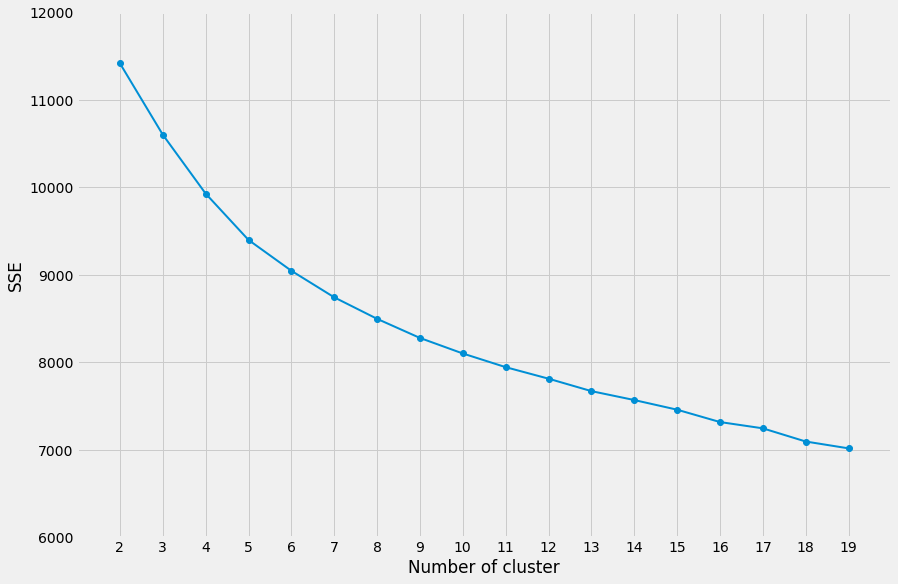

In [16]:
plt.figure(figsize=(13,9))
plt.plot(list(sse.keys()), list(sse.values()), "-o", linewidth=2)
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.ylim(6000, 12000)
plt.xlim(1,20)
plt.xticks(range(2,20))
plt.show()

Using the elbow method in this case is hard as there is no significant change in slope. 

Instead, we can find the place in which the slow down in pct %-change is the greatest.


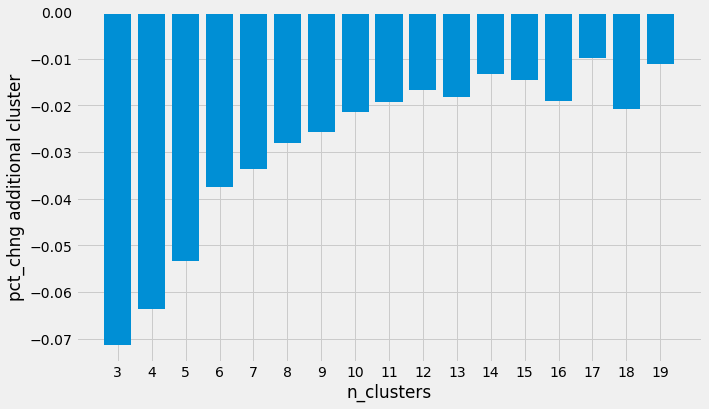

In [17]:
pct_change_clusters = pd.Series(sse.values()).pct_change()

plt.figure(figsize=(10,6))
plt.bar(sse.keys(), pct_change_clusters)
plt.xlabel("n_clusters")
plt.ylabel("pct_chng additional cluster")
plt.xticks(np.arange(3,20))
plt.show()

Looking at the bar chart graph we can see, that around 13 the pct changes kind of start balancing out. As such we decided to go for a cluster number of 13

In [18]:
# Setting k to 13 
k = 13

In [19]:
# Filling the NaN with 0
aisle_share_pivot = aisle_share_pivot.fillna(0)

### 2.5.2 Alternative Clustering methods 

During our clustering we had a branch that explored DBSCAN/OPTICS as an alternative method for segmentation. However, due to the size of the dataset DBSCAN quickly ran out of memory as the algorithm in SciKit Learn is optimized towards performance. OPTICS however could solve this but the computational time never concluded. Therefore, K-Means was the optimal clustering algorithm for this size of data. 

## 2.6 Preparing our dataframe for collaborative filtering

We can now prepare our dataframe for export to use in our collaborative filtering in the next section. This is done over a few steps of merging dataframes with the goal of shaping a final df consisting of order_id, product_id, cluster & user_id.


In [20]:
#concatting cluster onto 
cluster_df = pd.concat([PCA_components[range(d)], pd.Series(labels[k]).rename('cluster')], axis = 1)

cluster_df = pd.concat([pd.Series(aisle_share_pivot.index),cluster_df],axis = 1)

In [21]:
cluster_df

,user_id,0,1,2,3,4,5,6,7,8,...,24,25,26,27,28,29,30,31,32,cluster
0,1,-0.122382,0.028613,-0.047847,0.012767,-0.075248,-0.111791,-0.100797,0.088232,-0.063932,...,0.079287,0.025060,0.104362,0.029456,-0.021527,0.006139,0.008043,-0.005072,-0.011461,4
1,2,-0.034421,0.111616,-0.064131,-0.109468,0.073280,-0.029577,-0.049187,-0.058602,-0.010482,...,0.006804,-0.005423,-0.003019,-0.000217,0.002795,0.006918,-0.022622,-0.019917,0.027312,5
2,3,0.063256,0.104112,0.000496,-0.014156,-0.047741,0.111107,-0.031845,0.013015,0.011859,...,-0.005193,-0.000366,0.015456,-0.005741,-0.004336,-0.003815,0.003469,-0.014939,-0.017511,8
3,4,-0.094301,0.052755,0.001040,-0.005059,-0.071586,-0.017778,-0.025068,-0.039001,0.009993,...,0.006558,-0.000022,0.010985,-0.013485,0.016255,-0.007338,-0.064575,0.060007,0.033193,9
4,5,0.089432,-0.031068,-0.022805,-0.011826,0.042319,0.111460,-0.015760,0.100975,0.025137,...,0.007773,0.002408,-0.007447,-0.000222,-0.001055,-0.001942,0.004315,-0.009519,-0.003642,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,206205,0.001716,0.084855,-0.065398,-0.068637,0.114987,-0.028522,0.020656,0.023942,-0.027590,...,-0.025726,-0.007686,0.028825,-0.000518,-0.001827,0.017793,-0.016729,-0.005403,0.039125,5
206205,206206,-0.089658,-0.046734,-0.048290,0.012790,-0.059581,-0.000544,-0.013947,-0.042906,0.143137,...,0.044255,-0.008106,0.031527,0.033007,-0.031681,0.002545,-0.014003,-0.004219,-0.017396,3
206206,206207,-0.024827,-0.013520,-0.003968,-0.030921,0.032987,0.020687,0.037639,0.032876,-0.022797,...,-0.003637,0.013538,-0.009709,0.004822,-0.004506,0.005795,-0.008193,-0.008830,0.000235,12
206207,206208,-0.009310,-0.003375,-0.045594,-0.012231,0.013768,0.055684,0.008126,0.029497,-0.010673,...,-0.001145,-0.009144,0.012002,-0.000845,-0.004759,-0.005586,0.001994,-0.019439,-0.002063,8


In [22]:
#Adding cluster number to our asile share per user dataframe 
cluster_aisle_br = aisle_share_per_user.merge(cluster_df[['user_id','cluster']], on = 'user_id')

In [23]:
cluster_aisle_br

,user_id,aisle,aisle_share,cluster
0,1,candy chocolate,0.028571,4
1,1,cereal,0.057143,4
2,1,cream,0.042857,4
3,1,fresh fruits,0.071429,4
4,1,milk,0.014286,4
...,...,...,...,...
5919835,206209,soft drinks,0.080292,9
5919836,206209,soy lactosefree,0.072993,9
5919837,206209,spices seasonings,0.007299,9
5919838,206209,trash bags liners,0.007299,9


In [24]:
all_orders_cluster = all_orders.merge(cluster_df[['user_id','cluster']], on = 'user_id')

In [25]:
all_orders_cluster

,order_id,product_id,add_to_cart_order,reordered,user_id,product_name,aisle_id,department_id,department,aisle,cluster
0,2,33120,1,1,202279,Organic Egg Whites,86,16,dairy eggs,eggs,12
1,104690,33120,2,1,202279,Organic Egg Whites,86,16,dairy eggs,eggs,12
2,132412,33120,1,1,202279,Organic Egg Whites,86,16,dairy eggs,eggs,12
3,2808715,33120,1,1,202279,Organic Egg Whites,86,16,dairy eggs,eggs,12
4,2894949,33120,5,0,202279,Organic Egg Whites,86,16,dairy eggs,eggs,12
...,...,...,...,...,...,...,...,...,...,...,...
33819101,2942910,36885,1,1,95228,Rose,134,5,alcohol,specialty wines champagnes,9
33819102,77392,47713,1,1,95228,Sparkling Rose,134,5,alcohol,specialty wines champagnes,9
33819103,679020,47713,1,1,95228,Sparkling Rose,134,5,alcohol,specialty wines champagnes,9
33819104,1264096,47713,1,1,95228,Sparkling Rose,134,5,alcohol,specialty wines champagnes,9


## 2.7 Exploring the clusters

In [26]:
user_per_cluster = all_orders_cluster.groupby("cluster").nunique()["user_id"]

In [27]:
user_per_cluster

cluster
0     17053
1      9104
2     24138
3      3257
4      2647
5     10474
6      2437
7      7133
8     33941
9     47708
10     1596
11     4924
12    41797
Name: user_id, dtype: int64

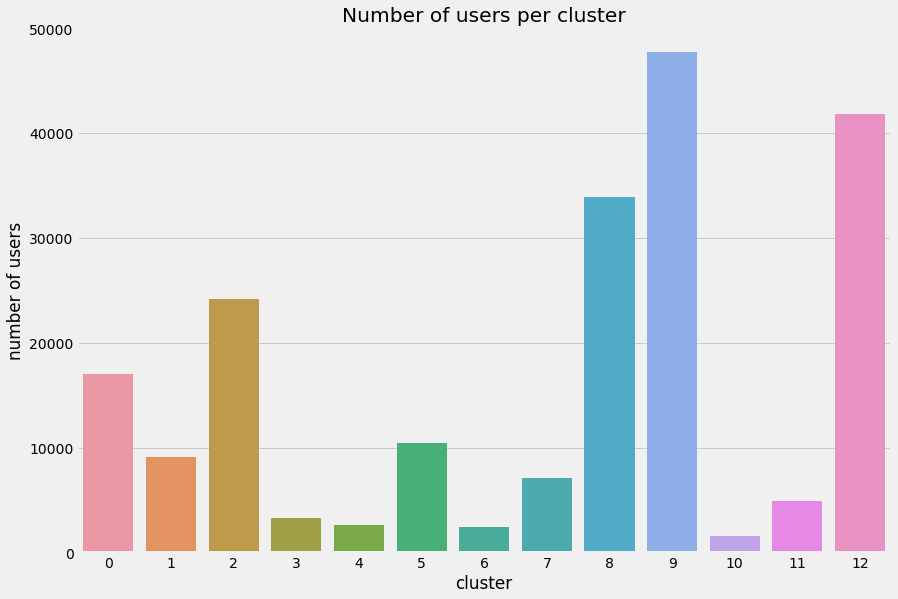

In [28]:
plt.figure(figsize=(13,9))
sns.barplot(x = user_per_cluster.index, y=user_per_cluster.values)
plt.title("Number of users per cluster")
plt.xlabel("cluster")
plt.ylabel("number of users")
plt.show()

In [29]:
orders_per_cluster=all_orders_cluster.groupby("cluster")["order_id"].nunique()

In [30]:
sum(orders_per_cluster.values)

3346083

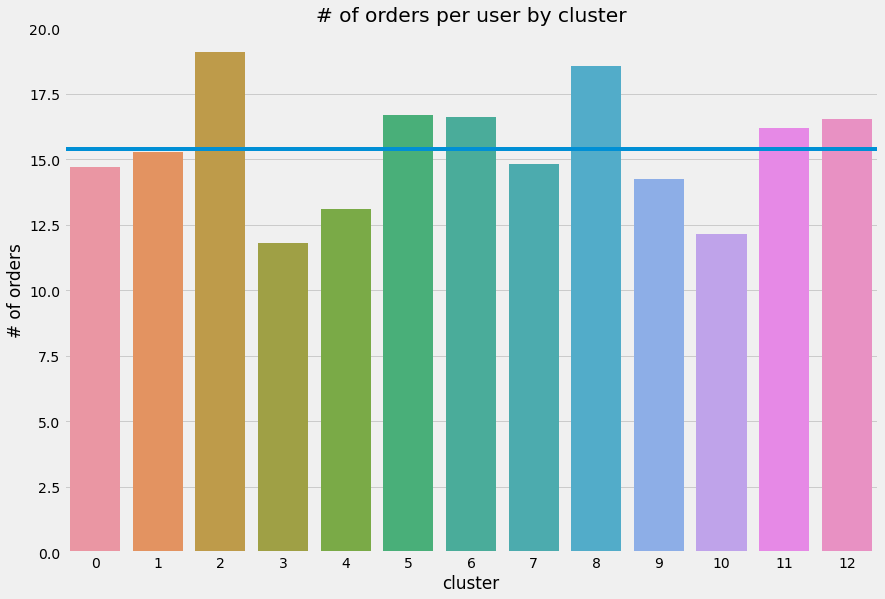

In [31]:
plt.figure(figsize=(13,9))
sns.barplot(x=orders_per_cluster.index, y=orders_per_cluster.values/user_per_cluster.values).axhline(np.mean(orders_per_cluster.values/user_per_cluster.values))
plt.title("# of orders per user by cluster")
plt.ylabel("# of orders")
plt.show()

In [32]:
avg_num_prod_per_order_by_cluster = all_orders_cluster.groupby(["cluster","order_id"]).count()["product_id"].groupby("cluster").mean()

In [33]:
avg_num_prod_per_order_by_cluster

cluster
0     10.407031
1      6.764036
2     11.219766
3      6.612025
4      4.174224
5     10.428435
6      4.215534
7      4.712432
8     11.003040
9      9.807354
10     3.586575
11     5.246421
12    11.735603
Name: product_id, dtype: float64

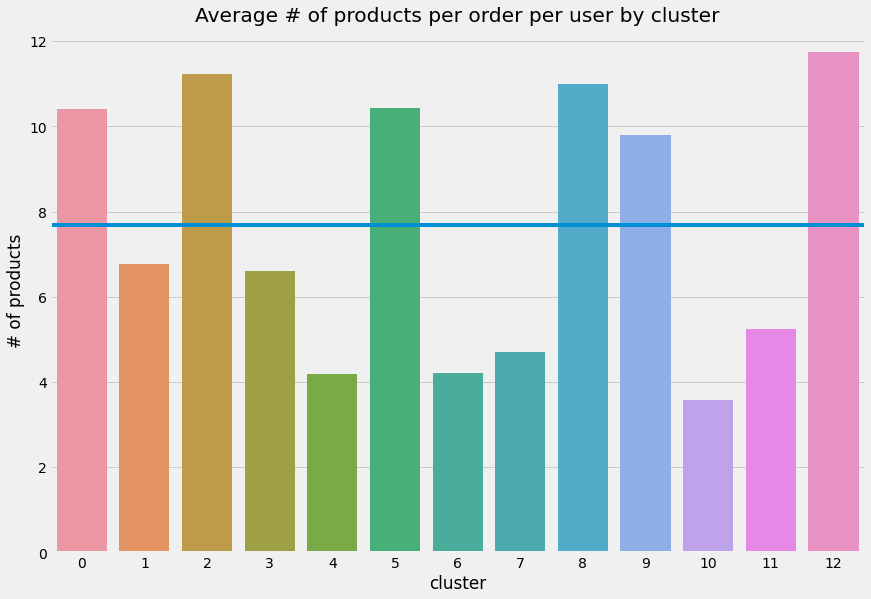

In [34]:
plt.figure(figsize=(13,9))
sns.barplot(x=avg_num_prod_per_order_by_cluster.index, y=avg_num_prod_per_order_by_cluster.values).axhline(np.mean(avg_num_prod_per_order_by_cluster))
plt.title("Average # of products per order per user by cluster")
plt.ylabel("# of products")
plt.show()

In [35]:
a = pd.DataFrame(all_orders_cluster.groupby(['cluster',"department"]).count())
a

order_id  product_id  add_to_cart_order  reordered  \
cluster department                                                          
0       alcohol            1295        1295               1295       1295   
        babies             8807        8807               8807       8807   
        bakery            55821       55821              55821      55821   
        beverages        111064      111064             111064     111064   
        breakfast         24869       24869              24869      24869   
...                         ...         ...                ...        ...   
12      pantry           566288      566288             566288     566288   
        personal care     97731       97731              97731      97731   
        pets              19282       19282              19282      19282   
        produce         2418347     2418347            2418347    2418347   
        snacks           598213      598213             598213     598213   

                       user_id  product_name  aisle_id  department_id    aisle  
cluster department                                                              
0       alcohol           1295          1295      1295           1295     1295  
        babies            8807          8807      8807           8807     8807  
        bakery           55821         55821     55821          55821    55821  
        beverages       111064        111064    111064         111064   111064  
        breakfast        24869         24869     24869          24869    24869  
...                        ...           ...       ...            ...      ...  
12      pantry          566288        566288    566288         566288   566288  
        personal care    97731         97731     97731          97731    97731  
        pets             19282         19282     19282          19282    19282  
        produce        2418347       2418347   2418347        2418347  2418347  
        snacks          598213        598213    598213         598213   598213  

[273 rows x 9 columns]

In [45]:
df_m = a[["order_id"]].unstack(level=0)

df_m

order_id                                                \
cluster               0       1        2      3      4       5      6    
department                                                               
alcohol             1295    7867     1715   2052   2552    3560    892   
babies              8807    5004    49278   1110    155   22150   1142   
bakery             55821   24229   144256   8435   2576   60254   5359   
beverages         111064  276074   236176  26502  59922  159617  16188   
breakfast          24869   21991    75700   5572   3489   55109   5644   
bulk                4458    1079     7561     95    143    1670    130   
canned goods      108957   14596   160872   5149   1337   38020   2006   
dairy eggs        322215  124502   793042  32702  12626  593531  73280   
deli               65476   22927   149337   7056   1869   55426   3217   
dry goods pasta    63436   11000   123799   4929    942   34774   1771   
frozen            105571   44476   251298  69325   5603  108251   6367   
household          28201   40481    49458   7269   6767   29268   3638   
international      27864    5194    37555   1795    531    9992    510   
meat seafood       65640   10543   118131   3738   1250   23928   1897   
missing             5738    2654    10657   1396    170    5309    181   
other               2129    1310     4156    370    293    1566    171   
pantry            157010   42176   254354  13237   5404   73034   7715   
personal care      19838   20958    38540   4905   2038   20211   1878   
pets                1967    3993     3178   1409    472    2939    209   
produce          1324332  128507  2374933  29900  11201  341022  24483   
snacks            108809  131357   284524  27207  25564  185658  14127   

                                                                  
cluster              7        8       9      10      11       12  
department                                                        
alcohol            1752    12643   99264    338     634    24730  
babies               50   158786   95609     60     616    95976  
bakery            12709   282513  314122    870    8740   305297  
beverages         30493   528315  752485  45749   25887   535703  
breakfast          8228   172643  211953    825    6379   146667  
bulk               1167     7118    3135     45     662     8669  
canned goods       9799   180184  234843    247    3483   355364  
dairy eggs        45901  1241072  998873   5125   54750  1333448  
deli               9365   261771  228379    849    7317   282551  
dry goods pasta    2880   178645  211327    130    2508   269199  
frozen            19657   490269  661855   1033   12485   560668  
household          7996   113557  327455   2054    3987   154521  
international       379    46298   57627    178    1020    92212  
meat seafood       7152   138711  148387    175    3524   216162  
missing             228    14184   16560    143     476    19700  
other               174     6396   12600     26     368     8527  
pantry            21570   344119  458246   1680   11986   566288  
personal care      2277    77343  179857    797    2320    97731  
pets                 29    10605   58013     38      87    19282  
produce          278584  1976553  737156   3839  239521  2418347  
snacks            38501   688870  865982   5418   32182   598213

In [47]:
dep_vol_per_cluster = df_m.divide(avg_num_prod_per_order_by_cluster.values, axis=1)

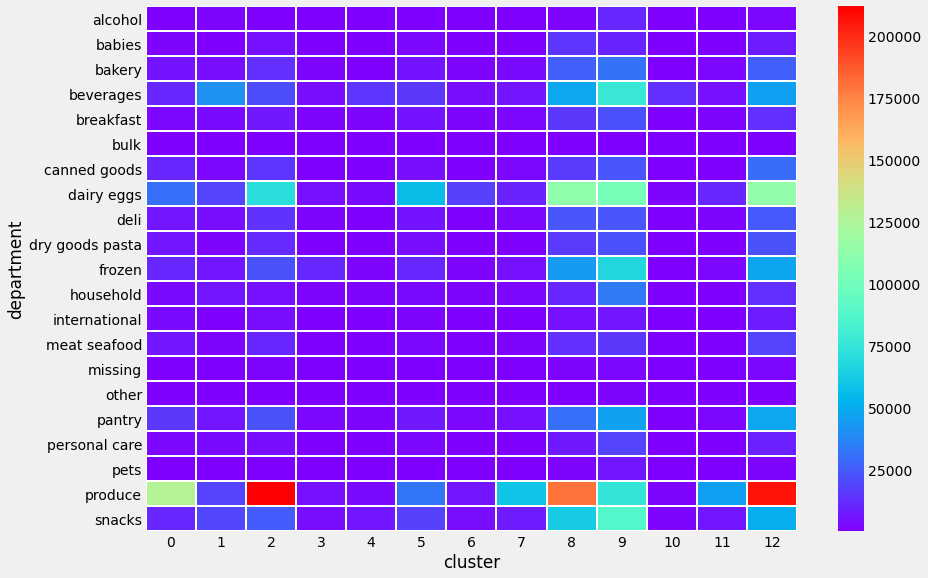

In [69]:
plt.figure(figsize=(13,9))
sns.heatmap(data=dep_vol_per_cluster, cmap="rainbow", linewidths=1, xticklabels=range(0,13))
plt.xlabel("cluster")
plt.show()

In [72]:
aisle_vol_per_cluster = all_orders_cluster.groupby(["cluster", "aisle"]).count()["order_id"].unstack(level=0).divide(avg_num_prod_per_order_by_cluster.values, axis=1)

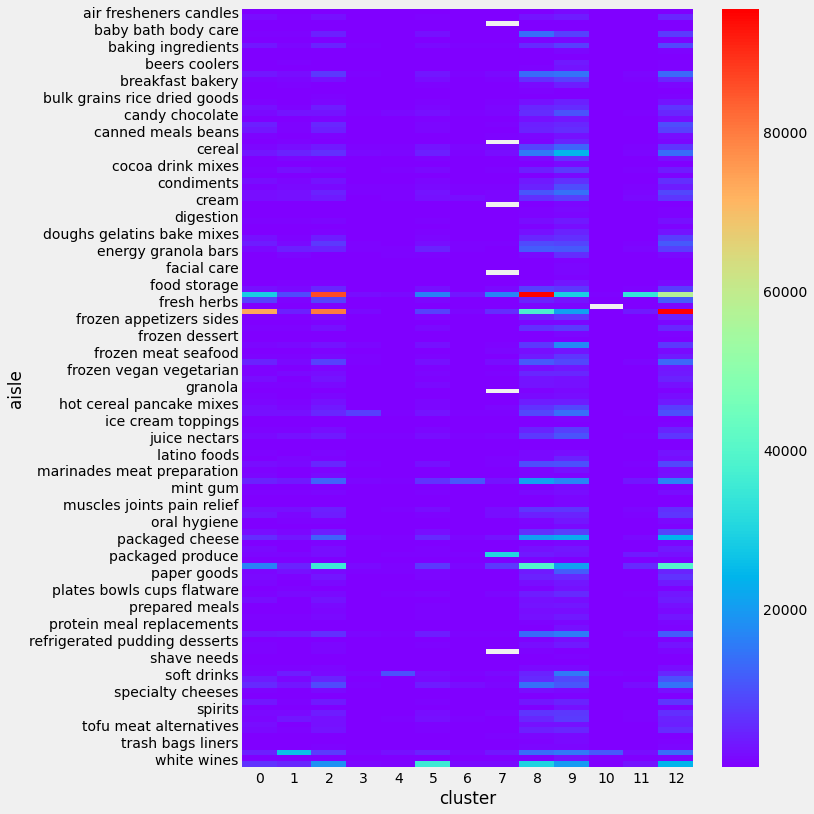

In [87]:
plt.figure(figsize=(9,13))
sns.heatmap(data=aisle_vol_per_cluster, cmap="rainbow", xticklabels=range(0,13))
plt.xlabel("cluster")
plt.show()

## 2.8 Exporting our clustered dataframe to pyarrow (for compression) for use in collaborative filtering algorithm.

In [46]:
dummy_df = all_orders_cluster[["order_id", "product_id", "cluster", "user_id"]]

In [27]:
table = pa.Table.from_pandas(dummy_df, preserve_index=False)

pq.write_table(table, f"dummy_k{k}.parquet")

ModuleNotFoundError: No module named 'pyarrow'

## Link to [3. item2vec](recommender_system/item2vec.ipynb) 